In [1]:
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img

%load_ext autoreload
%autoreload 2

# 0. Define the Loss function

As we encode the labels as well, cross entropy function should take the one-hot vector with softed value as an input.
However, cross entorpy function supported by pytorch only takes one dimensional label (e.g [1,0,9,...] where entries presents class labels).
Hence, now I define my cross entropy function here.

In [106]:
def my_cross_entropy(input, target, size_average=True):
    """ Cross entropy that accepts soft targets
    Args:
         pred: predictions for neural network
         targets: targets, can be soft
         size_average: if false, sum is returned instead of mean

    Examples::

        input = torch.FloatTensor([[1.1, 2.8, 1.3], [1.1, 2.1, 4.8]])
        input = torch.autograd.Variable(out, requires_grad=True)

        target = torch.FloatTensor([[0.05, 0.9, 0.05], [0.05, 0.05, 0.9]])
        target = torch.autograd.Variable(y1)
        loss = cross_entropy(input, target)
        loss.backward()
    """
    logsoftmax = nn.LogSoftmax(dim=1)
    if size_average:
        return torch.mean(torch.sum(-target * logsoftmax(input) , dim=1))
    else:
        return torch.sum(torch.sum(-target * logsoftmax(input), dim=1))

## 0.1. Test my_cross_entropy

In [107]:
from torch import nn, autograd

input = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
target = torch.LongTensor([2,4,0])

one_hot = torch.nn.functional.one_hot(target,num_classes=5)

print(input.dim())
print(target)
print(one_hot)



2
tensor([2, 4, 0])
tensor([[0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0]])


In [117]:
model = nn.Linear(2, 2)
model.weight = torch.FloatTensor([[1,0],[0,1]])
print(model.weight)
print(model.bias)
x = torch.randn(1, 2)
# target = torch.randn(1, 2)
output = model(x)
print(x)
print(output)
# loss = my_loss(output, target)
# loss.backward()
# print(model.weight.grad)

TypeError: cannot assign 'torch.FloatTensor' as parameter 'weight' (torch.nn.Parameter or None expected)

In [108]:
print("\nfollowing outputs should be same.")

loss = nn.CrossEntropyLoss()
loss_defalut = loss(input, target)
print(loss_defalut)
loss_defalut.backward()
print(loss_defalut)


print(loss(input, target))
print(my_cross_entropy(input, one_hot))


following outputs should be same.
tensor(2.6336, grad_fn=<NllLossBackward>)
tensor(2.6336, grad_fn=<NllLossBackward>)
tensor(2.6336, grad_fn=<NllLossBackward>)
tensor(2.6336, grad_fn=<MeanBackward0>)


In [122]:
out = torch.FloatTensor([[0.05, 0.9, 0.05], [0.05, 0.05, 0.9], [0.9, 0.05, 0.05]])
out = torch.autograd.Variable(out)

# Categorical targets
y = torch.LongTensor([1, 2, 0])
y = torch.autograd.Variable(y)

# One-hot encoded targets
y1 = torch.FloatTensor([[0, 1, 0], [0, 0, 1], [1, 0, 0]])
y1 = torch.autograd.Variable(y1)

print(y1)

# Calculating the loss
loss_val = nn.CrossEntropyLoss()(out, y)
loss_val1 = nn.BCEWithLogitsLoss()(out, y1)

print(loss_val)
print(loss_val1)

tensor([[0., 1., 0.],
        [0., 0., 1.],
        [1., 0., 0.]])
tensor(0.6178)
tensor(0.5927)


### Check whether my_cross_entropy function works properly with soft-valued one-hot vector

In [128]:
target = torch.LongTensor([2,4,0])
one_hot = torch.nn.functional.one_hot(target,num_classes=5)
print(one_hot)
print(my_cross_entropy(input, one_hot))
print()

print("check the soft valued one-hot vector")
one_hot = torch.FloatTensor([[0,0.1, 0.9, 0.1, 0],[0, 0, 0, 0.1, 0.9],[1.1, -0.1, 0,0,0]])
print(one_hot)
print(my_cross_entropy(input, one_hot))

tensor([[0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0]])
tensor(2.6336, grad_fn=<MeanBackward0>)

check the soft valued one-hot vector
tensor([[ 0.0000,  0.1000,  0.9000,  0.1000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.1000,  0.9000],
        [ 1.1000, -0.1000,  0.0000,  0.0000,  0.0000]])
tensor(2.6009, grad_fn=<MeanBackward0>)


# 1. Load MNIST dataset

In [284]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=128 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Default' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

In [285]:
args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
if args.dataset == 'mnist':
    trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
    dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
    dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)
    # sample users
    if args.iid:
        dict_users = mnist_iid(dataset_train, args.num_users)
    else:
        dict_users = mnist_noniid(dataset_train, args.num_users)
elif args.dataset == 'cifar':
    trans_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=trans_cifar)
    dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=trans_cifar)
    if args.iid:
        dict_users = cifar_iid(dataset_train, args.num_users)
    else:
        exit('Error: only consider IID setting in CIFAR10')
else:
    exit('Error: unrecognized dataset')
img_size = dataset_train[0][0].shape

# print(dataset_train[1])

# 2. Train CNN with Torch's CrossEntropy function

In [286]:
net_glob = CNNMnist2(args=args)
net_glob.cuda()

CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)

In [287]:
print(net_glob)
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

# training
loss_train = []
loss_test_arr_uncoded = []
acc_test_arr_uncoded = []

net_best = None
best_loss = None
val_acc_list, net_list = [], []

for iter in range(30): #args.epochs
    w_locals, loss_locals = [], []
    m = 15
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in idxs_users:
#         print(idx)
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    
    loss_train.append(loss_avg)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr_uncoded.append(acc_test)
    loss_test_arr_uncoded.append(loss_test)
    if iter % 1 ==0:
        print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
    #print(loss_train)

CNNMnist2(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
)

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.329 Test accuracy 9.800

Test set: Average loss: 2.1631 
Accuracy: 6283/10000 (62.83%)

Round   1, Average loss 1.881 Test accuracy 62.830

Test set: Average loss: 0.2181 
Accuracy: 9428/10000 (94.28%)

Round   2, Average loss 0.829 Test accuracy 94.280

Test set: Average loss: 0.1346 
Accuracy: 9625/10000 (96.25%)

Round   3, Average loss 0.428 Test accuracy 96.250

Test set: Average loss: 0.1026 
Accuracy: 9688/10000 (96.88%)

Round   4, Average loss 0.329 Test accuracy 96.880

Test set: Average loss: 0.0853 
Accuracy: 9754/10000 (97.54%)

Round   5, Average loss 0.286 Test accuracy 97.540

Test set: Average loss: 0.0773 
Accuracy: 9769/10000 (97.69%)

Round

# 3. Train CNN with Customized Loss function

In [126]:
args.loss='Custom' # 'Custom' or 'Default'

In [127]:
net_glob = CNNMnist2(args=args)
net_glob.cuda()
net_glob.train()

# copy weights
w_glob = net_glob.state_dict()

# training
loss_train = []
loss_test_arr = []
acc_test_arr = []
cv_loss, cv_acc = [], []
val_loss_pre, counter = 0, 0
net_best = None
best_loss = None
val_acc_list, net_list = [], []

for iter in range(10): #args.epochs
    w_locals, loss_locals = [], []
    m = 15
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    for idx in range(args.num_users):
#         print(idx)
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    
    loss_train.append(loss_avg)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)
    acc_test_arr.append(acc_test)
    loss_test_arr.append(loss_test)
    if iter % 1 ==0:
        print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_avg,acc_test))
    #print(loss_train)


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.309 Test accuracy 9.800

Test set: Average loss: 1.9062 
Accuracy: 8132/10000 (81.32%)

Round   1, Average loss 1.646 Test accuracy 81.320

Test set: Average loss: 0.1939 
Accuracy: 9448/10000 (94.48%)

Round   2, Average loss 0.732 Test accuracy 94.480

Test set: Average loss: 0.1276 
Accuracy: 9642/10000 (96.42%)

Round   3, Average loss 0.396 Test accuracy 96.420

Test set: Average loss: 0.1027 
Accuracy: 9705/10000 (97.05%)

Round   4, Average loss 0.320 Test accuracy 97.050

Test set: Average loss: 0.0857 
Accuracy: 9746/10000 (97.46%)

Round   5, Average loss 0.277 Test accuracy 97.460

Test set: Average loss: 0.0766 
Accuracy: 9767/10000 (97.67%)

Round   6, Average loss 0.249 Test accuracy 97.670

Test set: Average loss: 0.0694 
Accuracy: 9793/10000 (97.93%)

Round   7, Average loss 0.235 Test accuracy 97.930

Test set: Average loss: 0.0643 
Accuracy: 9805/10000 (98.05%)

Round   8, Average 

# 4. Train CNN by utilizing BACC (N=15, K=6)

## 4.1. BACC encoding for MNIST dataset

In [316]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 15  # "number of users: N"
    num_partition = 6 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

In [317]:
encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


In [318]:
from utils.functions import *
import math

N= args.num_users
K= args.num_partition


j_array = np.array(range(K))
# print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

alpha_array = np.cos((2*j_array+1)*math.pi/(2*K)) #np.cos((2*j_array+1)*math.pi/(2*K))
print("alpha_array: ",alpha_array,'\n')

i_array = np.array(range(N))
z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
print("z_array: ",z_array,'\n')

X_tilde = BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde = BACC_Enc(encoding_label_array_np, alpha_array, z_array)

alpha_array:  [ 0.96592583  0.70710678  0.25881905 -0.25881905 -0.70710678 -0.96592583] 

z_array:  [ 1.          0.9781476   0.91354546  0.80901699  0.66913061  0.5
  0.30901699  0.10452846 -0.10452846 -0.30901699 -0.5        -0.66913061
 -0.80901699 -0.91354546 -0.9781476 ] 

@BACC_Enc: N,K, m_i= 15 6 10000 

@BACC_Enc: N,K, m_i= 15 6 10000 



In [319]:
print(X_tilde.shape)
print(y_tilde.shape)

(15, 10000, 784)
(15, 10000, 10)


## 4.2 Train LeNet with BACC

In [320]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

# training
loss_train_arr = []
loss_test_arr = []
acc_test_arr = []
net_best = None
best_loss = None

N_trials = 1
N_epochs = 30

# m_array = np.array(range(4,16)) # m is the number of received result @ master
m_array = np.array([15]) # m is the number of received result @ master
loss_test_arr = np.empty((len(m_array),N_trials,N_epochs))
acc_test_arr  = np.empty((len(m_array),N_trials,N_epochs))

for m_idx in range(len(m_array)):   
    
    m = m_array[m_idx] # m is the number of received result @ master
    print('number of results:',m)
    
    for trial_idx in range(N_trials):
        print('(m=',m,') ',trial_idx,'-th Trial!!')
        
        net_glob = CNNMnist2(args=args)
        net_glob.cuda()
        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()

        for iter in range(N_epochs): #args.epochs
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array, dec_z_array)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
        #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

        #     loss_train_arr.append(loss_train)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr[m_idx][trial_idx][iter] = acc_test
            loss_test_arr[m_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
            #print(loss_train)

number of results: 15
(m= 15 )  0 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 2.2771 
Accuracy: 6257/10000 (62.57%)

Round   1, Average loss 2.277 Test accuracy 62.570
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 1.2245 
Accuracy: 9094/10000 (90.94%)

Round   2, Average loss 1.225 Test accuracy 90.940
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.2009 
Accuracy: 9503/10000 (95.03%)

Round   3, Average loss 0.201 Test accuracy 95.030
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Test set: Average loss: 0.1814 
Accuracy: 9520/10000 (95.20%)

Round   4, Average loss 0.181 Test accuracy 95.200
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]

Tes

In [323]:
filehandler = open("./plot/MNIST_LeNet_N15_K6_m15_test_acc","wb")
pickle.dump(acc_test_arr,filehandler)

(1, 1, 30)


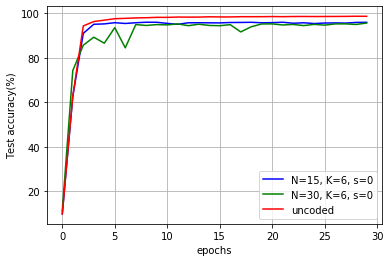

In [324]:
m_array = np.array([4,6,8,10,15,31]) # m is the number of received result @ master

plot_acc = np.mean(acc_test_arr, axis=1)

raw = pickle.load(open('./plot/MNIST_LeNet_N30_K6_m30_test_acc','rb'))
plot_acc_N30 = np.mean(raw, axis=1)
print(raw.shape)


plt.plot(plot_acc[0,:],'b',label='N=15, K=6, s=0')
plt.plot(plot_acc_N30[0,:],'g',label='N=30, K=6, s=0')
plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

import pickle

filehandler = open("./plot/MNIST_LeNet_N15_K6_m15_test_acc","wb")
pickle.dump(acc_test_arr,filehandler)

### N=15, K=6 (without averaging, i.e., N_trials = 1)

(5, 1, 30)
(5, 30)


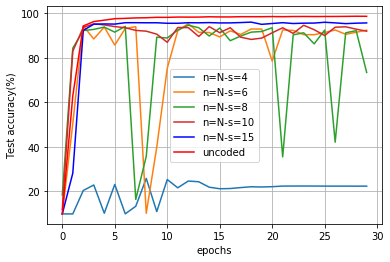

In [294]:
m_array = np.array([4,6,8,10,15])

plot_acc = np.mean(acc_test_arr, axis=1)
print(acc_test_arr.shape)
print(plot_acc.shape)

plt.plot(plot_acc[0,:],label='n=N-s=4')
plt.plot(plot_acc[1,:],label='n=N-s=6')
plt.plot(plot_acc[2,:],label='n=N-s=8')
plt.plot(plot_acc[3,:],label='n=N-s=10')
plt.plot(plot_acc[4,:],'b',label='n=N-s=15')
plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

import pickle

filehandler = open("./plot/MNIST_LeNet_N15_K6_m_4_6_8_10_15_test_acc","wb")
pickle.dump(acc_test_arr,filehandler)

(12, 10, 30)
(12, 30)


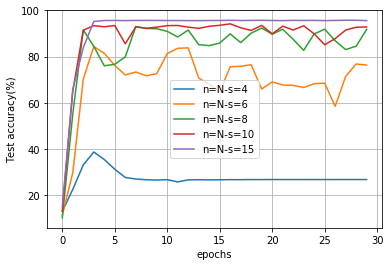

In [263]:
sel_m=10
sel_trial=0

plot_acc = np.mean(acc_test_arr, axis=1)
print(acc_test_arr.shape)
print(plot_acc.shape)

plt.plot(plot_acc[0,:],label='n=N-s=4')
plt.plot(plot_acc[2,:],label='n=N-s=6')
plt.plot(plot_acc[4,:],label='n=N-s=8')
plt.plot(plot_acc[6,:],label='n=N-s=10')
plt.plot(plot_acc[11,:],label='n=N-s=15')
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

import pickle

filehandler = open("./plot/MNIST_LeNet_N15_K6_test_acc","wb")
pickle.dump(acc_test_arr,filehandler)

# 5. Train CNN by utilizing BACC (N=31, K=12)

In [267]:
class my_argument:    
    epochs = 200    #"rounds of training"
    num_users = 31  # "number of users: N"
    num_partition = 12 # "number of users: K"
    frac = 0.5 #"the fraction of clients: C"
    local_ep = 1 #"the number of local epochs: E"
    local_bs = 200 #"local batch size: B"
    bs=200 #"test batch size"
    lr=0.01 #"learning rate"
    momentum=0.5 # "SGD momentum (default: 0.5)"
    split='user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='None' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='mnist' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

# load dataset and split users
trans_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
dataset_train = datasets.MNIST('../data/mnist/', train=True, download=True, transform=trans_mnist)
dataset_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=trans_mnist)

dict_users = mnist_iid(dataset_train, args.num_partition)

encoding_input_array_np = np.empty((len(dataset_train),28*28))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(60000/args.num_partition)

for i in range(args.num_partition):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,28*28))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np


# print(labels_np[0:10,:])

size of X: (60000, 784)
size of Y: (60000, 10)


In [268]:
from utils.functions import *
import math

N= args.num_users
K= args.num_partition


j_array = np.array(range(K))
# print("j: ",(2*j_array+1)*math.pi/2/K,'\n')

alpha_array = np.cos((2*j_array+1)*math.pi/(2*K)) #np.cos((2*j_array+1)*math.pi/(2*K))
print("alpha_array: ",alpha_array,'\n')

i_array = np.array(range(N))
z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
print("z_array: ",z_array,'\n')

X_tilde = BACC_Enc(encoding_input_array_np, alpha_array, z_array)
y_tilde = BACC_Enc(encoding_label_array_np, alpha_array, z_array)

alpha_array:  [ 0.99144486  0.92387953  0.79335334  0.60876143  0.38268343  0.13052619
 -0.13052619 -0.38268343 -0.60876143 -0.79335334 -0.92387953 -0.99144486] 

z_array:  [ 1.          0.99486932  0.97952994  0.95413926  0.91895781  0.87434662
  0.82076344  0.75875812  0.68896692  0.61210598  0.52896401  0.44039415
  0.34730525  0.25065253  0.15142778  0.05064917 -0.05064917 -0.15142778
 -0.25065253 -0.34730525 -0.44039415 -0.52896401 -0.61210598 -0.68896692
 -0.75875812 -0.82076344 -0.87434662 -0.91895781 -0.95413926 -0.97952994
 -0.99486932] 

@BACC_Enc: N,K, m_i= 31 12 5000 

@BACC_Enc: N,K, m_i= 31 12 5000 



In [269]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

# training
loss_train_arr = []
loss_test_arr = []
acc_test_arr = []
net_best = None
best_loss = None

N_trials = 10
N_epochs = 30

m_array = np.array([6,9,12,15,18,21,24,27,30]) # m is the number of received result @ master
loss_test_arr = np.empty((len(m_array),N_trials,N_epochs))
acc_test_arr  = np.empty((len(m_array),N_trials,N_epochs))

for m_idx in range(len(m_array)):   
    
    m = m_array[m_idx] # m is the number of received result @ master
    print('number of results:',m)
    
    for trial_idx in range(N_trials):
        print('(m=',m,') ',trial_idx,'-th Trial!!')
        
        net_glob = CNNMnist2(args=args)
        net_glob.cuda()
        net_glob.train()

        # copy weights
        w_glob = net_glob.state_dict()

        for iter in range(N_epochs): #args.epochs
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array, dec_z_array)

            # copy weight to net_glob
            net_glob.load_state_dict(w_glob)

            # print loss
        #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

        #     loss_train_arr.append(loss_train)

            acc_test, loss_test = test_img(net_glob, dataset_test, args)
            acc_test_arr[m_idx][trial_idx][iter] = acc_test
            loss_test_arr[m_idx][trial_idx][iter] = loss_test
            if iter % 1 ==0:
                print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
            #print(loss_train)

number of results: 6
(m= 6 )  0 -th Trial!!
selected users: [15 16 19 20 23 30]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 5  6 10 11 18 19]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   1, Average loss 2.303 Test accuracy 9.800
selected users: [ 4  7  9 15 19 24]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   2, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  4  5 12 13 30]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   3, Average loss 2.303 Test accuracy 9.800
selected users: [ 5 18 20 21 25 28]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   4, Average loss 2.303 Test accuracy 9.800
selected users: [ 5  6 19 23 25 30]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   5, Average loss 2.303 Test accuracy 9.800
selected users: [ 3 13 14 18 21 26]

Test set: Average loss: 2.3026 


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  25, Average loss 2.303 Test accuracy 9.800
selected users: [ 2  3  5 10 14 16]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  26, Average loss 2.303 Test accuracy 9.800
selected users: [ 2 12 15 18 21 29]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  27, Average loss 2.303 Test accuracy 9.800
selected users: [ 3  6 10 17 20 25]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  28, Average loss 2.303 Test accuracy 9.800
selected users: [ 8 13 14 20 29 30]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  29, Average loss 2.303 Test accuracy 9.800
(m= 6 )  2 -th Trial!!
selected users: [ 4  8 10 22 25 26]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 5  6 12 19 26 28]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   1, Average loss 2.3


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  20, Average loss 2.303 Test accuracy 9.800
selected users: [ 2  4 12 14 25 28]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  21, Average loss 2.303 Test accuracy 9.800
selected users: [ 1  3  5  7 28 30]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  22, Average loss 2.303 Test accuracy 9.800
selected users: [ 4  9 12 13 20 29]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  23, Average loss 2.303 Test accuracy 9.800
selected users: [ 4 19 20 24 25 29]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  24, Average loss 2.303 Test accuracy 9.800
selected users: [ 6 12 13 18 19 22]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  25, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  8 17 20 22 23]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  26, Average loss 2.303 Test accuracy 9.800



Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  16, Average loss 2.303 Test accuracy 9.800
selected users: [ 9 15 16 20 21 22]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  17, Average loss 2.303 Test accuracy 9.800
selected users: [ 1  2  6 12 26 27]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  18, Average loss 2.303 Test accuracy 9.800
selected users: [ 3  7  8 12 15 26]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  19, Average loss 2.303 Test accuracy 9.800
selected users: [ 2  7 15 22 29 30]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  20, Average loss 2.303 Test accuracy 9.800
selected users: [ 7 14 16 19 20 22]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  21, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  4  8 13 19]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round  22, Average loss 2.303 Test accuracy 9.800



Test set: Average loss: 2.2975 
Accuracy: 1002/10000 (10.02%)

Round   8, Average loss 2.298 Test accuracy 10.020
selected users: [ 0  3  4  5  8 18]

Test set: Average loss: 2.2984 
Accuracy: 998/10000 (9.98%)

Round   9, Average loss 2.298 Test accuracy 9.980
selected users: [ 2  3 13 17 22 23]

Test set: Average loss: 4050.7462 
Accuracy: 1229/10000 (12.29%)

Round  10, Average loss 4050.746 Test accuracy 12.290
selected users: [ 3  4 16 17 21 24]

Test set: Average loss: 2.2821 
Accuracy: 1069/10000 (10.69%)

Round  11, Average loss 2.282 Test accuracy 10.690
selected users: [ 1  2  8 12 18 29]

Test set: Average loss: 2.2865 
Accuracy: 1050/10000 (10.50%)

Round  12, Average loss 2.286 Test accuracy 10.500
selected users: [ 0  3 14 17 22 26]

Test set: Average loss: 2.2899 
Accuracy: 1035/10000 (10.35%)

Round  13, Average loss 2.290 Test accuracy 10.350
selected users: [ 0  8 12 21 25 30]

Test set: Average loss: 2.2888 
Accuracy: 1040/10000 (10.40%)

Round  14, Average loss 2.2


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   3, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  3  4 19 26 29]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   4, Average loss 2.303 Test accuracy 9.800
selected users: [11 14 20 23 26 28]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   5, Average loss 2.303 Test accuracy 9.800
selected users: [ 5 15 23 24 25 27]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   6, Average loss 2.303 Test accuracy 9.800
selected users: [10 16 21 22 26 28]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   7, Average loss 2.303 Test accuracy 9.800
selected users: [ 1  2 11 13 21 29]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   8, Average loss 2.303 Test accuracy 9.800
selected users: [ 9 12 16 17 21 28]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   9, Average loss 2.303 Test accuracy 9.800



Test set: Average loss: 263001412.4032 
Accuracy: 9583/10000 (95.83%)

Round  25, Average loss 263001412.403 Test accuracy 95.830
selected users: [ 0  4  6 12 13 15 16 24 29]

Test set: Average loss: 628724646.7072 
Accuracy: 9582/10000 (95.82%)

Round  26, Average loss 628724646.707 Test accuracy 95.820
selected users: [ 7  8 15 20 21 23 24 27 30]

Test set: Average loss: 1503109686.8864 
Accuracy: 9582/10000 (95.82%)

Round  27, Average loss 1503109686.886 Test accuracy 95.820
selected users: [ 2  3  4  7 10 11 18 23 26]

Test set: Average loss: 3586858382.1312 
Accuracy: 9578/10000 (95.78%)

Round  28, Average loss 3586858382.131 Test accuracy 95.780
selected users: [ 3  7 10 11 13 17 21 22 28]

Test set: Average loss: 8466582935.9616 
Accuracy: 9577/10000 (95.77%)

Round  29, Average loss 8466582935.962 Test accuracy 95.770
(m= 9 )  1 -th Trial!!
selected users: [ 0  1  2  4  6 20 22 24 29]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303


Test set: Average loss: 10654.3964 
Accuracy: 9298/10000 (92.98%)

Round  14, Average loss 10654.396 Test accuracy 92.980
selected users: [ 1  5  7  8 12 15 17 26 29]

Test set: Average loss: 23878.9069 
Accuracy: 9316/10000 (93.16%)

Round  15, Average loss 23878.907 Test accuracy 93.160
selected users: [ 1  4  6  9 13 14 23 24 25]

Test set: Average loss: 51602.2263 
Accuracy: 9357/10000 (93.57%)

Round  16, Average loss 51602.226 Test accuracy 93.570
selected users: [ 0  6  8  9 12 15 25 27 29]

Test set: Average loss: 125313.2770 
Accuracy: 9356/10000 (93.56%)

Round  17, Average loss 125313.277 Test accuracy 93.560
selected users: [ 1  9 12 14 16 19 20 23 28]

Test set: Average loss: 254749.8428 
Accuracy: 9394/10000 (93.94%)

Round  18, Average loss 254749.843 Test accuracy 93.940
selected users: [ 1  4  5  6 11 14 22 23 26]

Test set: Average loss: 628315.3952 
Accuracy: 9383/10000 (93.83%)

Round  19, Average loss 628315.395 Test accuracy 93.830
selected users: [ 2  3  9 10 12


Test set: Average loss: 0.5572 
Accuracy: 8252/10000 (82.52%)

Round   3, Average loss 0.557 Test accuracy 82.520
selected users: [ 1  3 10 12 13 18 20 22 30]

Test set: Average loss: 0.6204 
Accuracy: 9494/10000 (94.94%)

Round   4, Average loss 0.620 Test accuracy 94.940
selected users: [ 3  7  9 11 21 23 25 26 29]

Test set: Average loss: 6.0137 
Accuracy: 9325/10000 (93.25%)

Round   5, Average loss 6.014 Test accuracy 93.250
selected users: [ 1  4  7  8 12 19 21 28 29]

Test set: Average loss: 4.6866 
Accuracy: 9502/10000 (95.02%)

Round   6, Average loss 4.687 Test accuracy 95.020
selected users: [ 0  2 10 14 16 24 26 28 29]

Test set: Average loss: 10.8125 
Accuracy: 9297/10000 (92.97%)

Round   7, Average loss 10.813 Test accuracy 92.970
selected users: [ 0  3  4 16 17 18 22 23 27]

Test set: Average loss: 490.0241 
Accuracy: 9193/10000 (91.93%)

Round   8, Average loss 490.024 Test accuracy 91.930
selected users: [ 3  4  5 15 17 22 25 27 29]

Test set: Average loss: 780.5161 


Test set: Average loss: 2847331.0464 
Accuracy: 9583/10000 (95.83%)

Round  23, Average loss 2847331.046 Test accuracy 95.830
selected users: [ 1  6  9 14 17 18 19 20 22]

Test set: Average loss: 6182209.9520 
Accuracy: 9606/10000 (96.06%)

Round  24, Average loss 6182209.952 Test accuracy 96.060
selected users: [ 4  5  6  7  9 15 21 23 25]

Test set: Average loss: 15576707.9680 
Accuracy: 9597/10000 (95.97%)

Round  25, Average loss 15576707.968 Test accuracy 95.970
selected users: [ 0  2  3  6  7 12 15 19 22]

Test set: Average loss: 36657109.4016 
Accuracy: 9600/10000 (96.00%)

Round  26, Average loss 36657109.402 Test accuracy 96.000
selected users: [ 9 11 12 16 17 23 25 26 29]

Test set: Average loss: 83118491.6480 
Accuracy: 9605/10000 (96.05%)

Round  27, Average loss 83118491.648 Test accuracy 96.050
selected users: [ 0  3  5  8  9 12 17 18 24]

Test set: Average loss: 195906632.0896 
Accuracy: 9603/10000 (96.03%)

Round  28, Average loss 195906632.090 Test accuracy 96.030
sel


Test set: Average loss: 3348.3394 
Accuracy: 9407/10000 (94.07%)

Round  12, Average loss 3348.339 Test accuracy 94.070
selected users: [ 0  1  4  5  6 15 24 26 30]

Test set: Average loss: 9510.9690 
Accuracy: 9404/10000 (94.04%)

Round  13, Average loss 9510.969 Test accuracy 94.040
selected users: [ 2  6  7 14 17 19 23 27 30]

Test set: Average loss: 15096.7941 
Accuracy: 9465/10000 (94.65%)

Round  14, Average loss 15096.794 Test accuracy 94.650
selected users: [ 2  3  4  7  8 13 23 26 28]

Test set: Average loss: 29668.8815 
Accuracy: 9478/10000 (94.78%)

Round  15, Average loss 29668.881 Test accuracy 94.780
selected users: [ 1  3  4 11 13 18 19 25 30]

Test set: Average loss: 91639.9292 
Accuracy: 9477/10000 (94.77%)

Round  16, Average loss 91639.929 Test accuracy 94.770
selected users: [ 1  3 10 14 16 18 22 24 28]

Test set: Average loss: 195951.7388 
Accuracy: 9470/10000 (94.70%)

Round  17, Average loss 195951.739 Test accuracy 94.700
selected users: [ 3  5 15 16 18 22 24 2


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 5  8  9 11 13 20 26 28 29]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   1, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  5  8 11 16 17 24 26 30]

Test set: Average loss: 0.7852 
Accuracy: 7844/10000 (78.44%)

Round   2, Average loss 0.785 Test accuracy 78.440
selected users: [ 1 11 14 17 19 21 25 26 27]

Test set: Average loss: 0.3937 
Accuracy: 9532/10000 (95.32%)

Round   3, Average loss 0.394 Test accuracy 95.320
selected users: [ 1  6  8  9 10 14 26 27 30]

Test set: Average loss: 5.0299 
Accuracy: 9471/10000 (94.71%)

Round   4, Average loss 5.030 Test accuracy 94.710
selected users: [ 1  2  6 11 14 20 22 25 28]

Test set: Average loss: 8.3829 
Accuracy: 9500/10000 (95.00%)

Round   5, Average loss 8.383 Test accuracy 95.000
selected users: [ 0  1  5 15 17 19 26 27 29]

Test set: Average loss: 101.0847 
Accuracy: 9


Test set: Average loss: 39.2936 
Accuracy: 9332/10000 (93.32%)

Round  19, Average loss 39.294 Test accuracy 93.320
selected users: [ 1  8  9 11 15 16 18 19 20 21 29 30]

Test set: Average loss: 30.8454 
Accuracy: 8967/10000 (89.67%)

Round  20, Average loss 30.845 Test accuracy 89.670
selected users: [ 0  1  4  6  8 11 13 15 17 24 26 29]

Test set: Average loss: 27.3152 
Accuracy: 9368/10000 (93.68%)

Round  21, Average loss 27.315 Test accuracy 93.680
selected users: [ 0  2  3  5  7 10 14 15 21 23 25 26]

Test set: Average loss: 556.6399 
Accuracy: 8866/10000 (88.66%)

Round  22, Average loss 556.640 Test accuracy 88.660
selected users: [ 0  2  3  7 11 14 19 21 22 23 24 27]

Test set: Average loss: 137.3840 
Accuracy: 9309/10000 (93.09%)

Round  23, Average loss 137.384 Test accuracy 93.090
selected users: [ 1  2  4  5 10 11 12 15 20 25 29 30]

Test set: Average loss: 331.2988 
Accuracy: 9117/10000 (91.17%)

Round  24, Average loss 331.299 Test accuracy 91.170
selected users: [ 2  4


Test set: Average loss: 3.3156 
Accuracy: 9390/10000 (93.90%)

Round   7, Average loss 3.316 Test accuracy 93.900
selected users: [ 1  3  8  9 17 18 19 21 22 23 26 28]

Test set: Average loss: 1.7806 
Accuracy: 6055/10000 (60.55%)

Round   8, Average loss 1.781 Test accuracy 60.550
selected users: [ 1  4  5 10 17 19 20 21 24 26 27 29]

Test set: Average loss: 0.8460 
Accuracy: 9403/10000 (94.03%)

Round   9, Average loss 0.846 Test accuracy 94.030
selected users: [ 0  2  3  7 10 13 15 19 20 22 25 26]

Test set: Average loss: 2.5993 
Accuracy: 9346/10000 (93.46%)

Round  10, Average loss 2.599 Test accuracy 93.460
selected users: [ 0  2  3  9 10 11 13 14 17 21 23 29]

Test set: Average loss: 0.3361 
Accuracy: 9509/10000 (95.09%)

Round  11, Average loss 0.336 Test accuracy 95.090
selected users: [ 1  6  7 10 14 16 20 21 22 23 24 30]

Test set: Average loss: 4.3850 
Accuracy: 9395/10000 (93.95%)

Round  12, Average loss 4.385 Test accuracy 93.950
selected users: [ 8 10 12 13 14 16 17 20


Test set: Average loss: 114.9624 
Accuracy: 9034/10000 (90.34%)

Round  26, Average loss 114.962 Test accuracy 90.340
selected users: [ 1  3  7  8 10 11 13 15 19 25 28 29]

Test set: Average loss: 157.8692 
Accuracy: 9297/10000 (92.97%)

Round  27, Average loss 157.869 Test accuracy 92.970
selected users: [ 5  6  7 10 12 13 16 20 21 22 24 26]

Test set: Average loss: 835.4856 
Accuracy: 9104/10000 (91.04%)

Round  28, Average loss 835.486 Test accuracy 91.040
selected users: [ 0  1  7 11 13 17 21 22 23 26 27 29]

Test set: Average loss: 320.4820 
Accuracy: 9330/10000 (93.30%)

Round  29, Average loss 320.482 Test accuracy 93.300
(m= 12 )  4 -th Trial!!
selected users: [ 2  3  7 13 14 15 17 18 21 27 28 29]

Test set: Average loss: 2.3025 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.302 Test accuracy 9.800
selected users: [ 3  4  8 13 14 15 18 19 21 23 26 29]

Test set: Average loss: 1.8036 
Accuracy: 6948/10000 (69.48%)

Round   1, Average loss 1.804 Test accuracy 69.480
sel


Test set: Average loss: 0.7005 
Accuracy: 9229/10000 (92.29%)

Round  14, Average loss 0.700 Test accuracy 92.290
selected users: [ 2  5  6  7  8 13 14 24 25 26 27 30]

Test set: Average loss: 0.2707 
Accuracy: 9326/10000 (93.26%)

Round  15, Average loss 0.271 Test accuracy 93.260
selected users: [ 1  2  3  4  8 11 16 17 20 23 24 30]

Test set: Average loss: 4.4076 
Accuracy: 9294/10000 (92.94%)

Round  16, Average loss 4.408 Test accuracy 92.940
selected users: [ 0  1  2  8  9 11 19 21 23 24 28 29]

Test set: Average loss: 1.4549 
Accuracy: 9249/10000 (92.49%)

Round  17, Average loss 1.455 Test accuracy 92.490
selected users: [ 2  4  5  8 10 12 14 15 19 20 23 28]

Test set: Average loss: 1.8794 
Accuracy: 9204/10000 (92.04%)

Round  18, Average loss 1.879 Test accuracy 92.040
selected users: [ 0  1  8 11 12 14 18 21 22 24 25 29]

Test set: Average loss: 0.4171 
Accuracy: 9399/10000 (93.99%)

Round  19, Average loss 0.417 Test accuracy 93.990
selected users: [ 1  6  9 11 12 14 15 16


Test set: Average loss: 0.7932 
Accuracy: 8571/10000 (85.71%)

Round   2, Average loss 0.793 Test accuracy 85.710
selected users: [ 1  8  9 13 15 16 17 21 23 25 29 30]

Test set: Average loss: 0.2783 
Accuracy: 9299/10000 (92.99%)

Round   3, Average loss 0.278 Test accuracy 92.990
selected users: [ 1  3  6 10 11 12 13 18 21 24 26 27]

Test set: Average loss: 0.1903 
Accuracy: 9468/10000 (94.68%)

Round   4, Average loss 0.190 Test accuracy 94.680
selected users: [ 2  6  8 11 12 15 16 17 19 22 29 30]

Test set: Average loss: 0.1552 
Accuracy: 9533/10000 (95.33%)

Round   5, Average loss 0.155 Test accuracy 95.330
selected users: [ 5  7 11 12 15 16 17 19 21 23 24 25]

Test set: Average loss: 2.1324 
Accuracy: 9314/10000 (93.14%)

Round   6, Average loss 2.132 Test accuracy 93.140
selected users: [ 2  4  6 12 13 14 15 16 19 20 21 22]

Test set: Average loss: 1.5515 
Accuracy: 5178/10000 (51.78%)

Round   7, Average loss 1.552 Test accuracy 51.780
selected users: [ 1  5  9 10 14 18 21 22


Test set: Average loss: 71.2994 
Accuracy: 9271/10000 (92.71%)

Round  20, Average loss 71.299 Test accuracy 92.710
selected users: [ 3  4  6 12 13 18 21 23 26 27 28 30]

Test set: Average loss: 107.5425 
Accuracy: 9276/10000 (92.76%)

Round  21, Average loss 107.543 Test accuracy 92.760
selected users: [ 0  2  4  9 11 13 15 16 18 23 26 27]

Test set: Average loss: 171.5210 
Accuracy: 9325/10000 (93.25%)

Round  22, Average loss 171.521 Test accuracy 93.250
selected users: [ 0  2  5  6  9 12 16 18 19 20 24 29]

Test set: Average loss: 85.5265 
Accuracy: 9354/10000 (93.54%)

Round  23, Average loss 85.526 Test accuracy 93.540
selected users: [ 0  2  3  4  6  7  8 17 18 22 24 29]

Test set: Average loss: 73.4620 
Accuracy: 9304/10000 (93.04%)

Round  24, Average loss 73.462 Test accuracy 93.040
selected users: [ 1  3 12 15 16 17 18 23 24 27 28 30]

Test set: Average loss: 45.9971 
Accuracy: 9286/10000 (92.86%)

Round  25, Average loss 45.997 Test accuracy 92.860
selected users: [ 0  1  


Test set: Average loss: 0.5208 
Accuracy: 9176/10000 (91.76%)

Round   8, Average loss 0.521 Test accuracy 91.760
selected users: [ 8  9 10 11 12 15 17 20 22 23 24 25 27 29 30]

Test set: Average loss: 0.3293 
Accuracy: 9178/10000 (91.78%)

Round   9, Average loss 0.329 Test accuracy 91.780
selected users: [ 4  7  8 10 11 12 13 15 16 17 19 20 22 24 26]

Test set: Average loss: 1.0389 
Accuracy: 9262/10000 (92.62%)

Round  10, Average loss 1.039 Test accuracy 92.620
selected users: [ 0  1  2  4  5  6  8 14 16 18 19 22 23 24 30]

Test set: Average loss: 0.1898 
Accuracy: 9444/10000 (94.44%)

Round  11, Average loss 0.190 Test accuracy 94.440
selected users: [ 0  1  2  3  4  5 12 13 15 17 19 20 23 27 30]

Test set: Average loss: 0.6649 
Accuracy: 9194/10000 (91.94%)

Round  12, Average loss 0.665 Test accuracy 91.940
selected users: [ 1  3  4  5  6  8  9 14 16 18 19 20 24 26 29]

Test set: Average loss: 0.2043 
Accuracy: 9462/10000 (94.62%)

Round  13, Average loss 0.204 Test accuracy 94


Test set: Average loss: 0.2668 
Accuracy: 9391/10000 (93.91%)

Round  24, Average loss 0.267 Test accuracy 93.910
selected users: [ 0  2  3  4  6 10 11 13 14 16 19 20 23 27 28]

Test set: Average loss: 1.0439 
Accuracy: 9274/10000 (92.74%)

Round  25, Average loss 1.044 Test accuracy 92.740
selected users: [ 2  3  4  8  9 10 11 19 20 22 23 24 25 26 28]

Test set: Average loss: 0.2200 
Accuracy: 9515/10000 (95.15%)

Round  26, Average loss 0.220 Test accuracy 95.150
selected users: [ 8 12 13 14 15 16 18 19 20 23 26 27 28 29 30]

Test set: Average loss: 0.4296 
Accuracy: 9330/10000 (93.30%)

Round  27, Average loss 0.430 Test accuracy 93.300
selected users: [ 0  5 10 11 13 15 16 17 21 22 23 24 25 27 28]

Test set: Average loss: 3.3994 
Accuracy: 8958/10000 (89.58%)

Round  28, Average loss 3.399 Test accuracy 89.580
selected users: [ 0  2  3  7 10 11 12 16 19 20 21 24 26 28 29]

Test set: Average loss: 1.1438 
Accuracy: 9027/10000 (90.27%)

Round  29, Average loss 1.144 Test accuracy 90


Test set: Average loss: 0.1808 
Accuracy: 9445/10000 (94.45%)

Round  10, Average loss 0.181 Test accuracy 94.450
selected users: [ 2  4  7  9 13 15 18 20 21 24 25 26 27 28 30]

Test set: Average loss: 0.2030 
Accuracy: 9510/10000 (95.10%)

Round  11, Average loss 0.203 Test accuracy 95.100
selected users: [ 0  3  5  6  7 10 11 14 16 19 21 25 26 28 29]

Test set: Average loss: 0.7711 
Accuracy: 9349/10000 (93.49%)

Round  12, Average loss 0.771 Test accuracy 93.490
selected users: [ 0  6  7  9 11 12 13 16 18 21 22 23 24 29 30]

Test set: Average loss: 0.3446 
Accuracy: 9368/10000 (93.68%)

Round  13, Average loss 0.345 Test accuracy 93.680
selected users: [ 1  3  5  6  7 10 11 12 16 17 20 23 24 28 29]

Test set: Average loss: 0.4464 
Accuracy: 9359/10000 (93.59%)

Round  14, Average loss 0.446 Test accuracy 93.590
selected users: [ 2  4  6  7  9 11 12 13 14 15 18 19 25 27 30]

Test set: Average loss: 0.4213 
Accuracy: 9462/10000 (94.62%)

Round  15, Average loss 0.421 Test accuracy 94


Test set: Average loss: 1.5198 
Accuracy: 9207/10000 (92.07%)

Round  26, Average loss 1.520 Test accuracy 92.070
selected users: [ 2  3  4  6 10 14 15 19 20 21 23 24 27 29 30]

Test set: Average loss: 1.0833 
Accuracy: 9306/10000 (93.06%)

Round  27, Average loss 1.083 Test accuracy 93.060
selected users: [ 0  1  3  4  5  7  8 10 15 16 18 21 24 26 28]

Test set: Average loss: 1.2098 
Accuracy: 9079/10000 (90.79%)

Round  28, Average loss 1.210 Test accuracy 90.790
selected users: [ 0  2  4  7  8 10 13 14 15 16 21 24 28 29 30]

Test set: Average loss: 2.4040 
Accuracy: 9187/10000 (91.87%)

Round  29, Average loss 2.404 Test accuracy 91.870
(m= 15 )  5 -th Trial!!
selected users: [ 1  3  6  9 10 12 15 17 20 22 24 25 26 28 30]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  5  7  9 11 12 15 16 17 20 21 22 24]

Test set: Average loss: 2.1517 
Accuracy: 6197/10000 (61.97%)

Round   1, Average loss 2


Test set: Average loss: 0.1544 
Accuracy: 9555/10000 (95.55%)

Round  12, Average loss 0.154 Test accuracy 95.550
selected users: [ 0  2  3  5  8  9 13 14 17 19 25 26 27 29 30]

Test set: Average loss: 0.2063 
Accuracy: 9545/10000 (95.45%)

Round  13, Average loss 0.206 Test accuracy 95.450
selected users: [ 3  8 11 13 14 15 16 17 18 19 20 22 23 24 25]

Test set: Average loss: 0.2634 
Accuracy: 9363/10000 (93.63%)

Round  14, Average loss 0.263 Test accuracy 93.630
selected users: [ 2  3  4  5  7  9 11 12 15 17 19 20 24 27 30]

Test set: Average loss: 0.1951 
Accuracy: 9503/10000 (95.03%)

Round  15, Average loss 0.195 Test accuracy 95.030
selected users: [ 1  2  3  8 10 12 14 16 18 20 26 27 28 29 30]

Test set: Average loss: 0.5912 
Accuracy: 9342/10000 (93.42%)

Round  16, Average loss 0.591 Test accuracy 93.420
selected users: [ 0  1  2  4  8  9 14 15 21 22 24 25 27 29 30]

Test set: Average loss: 0.3875 
Accuracy: 9471/10000 (94.71%)

Round  17, Average loss 0.387 Test accuracy 94


Test set: Average loss: 1.5214 
Accuracy: 9209/10000 (92.09%)

Round  28, Average loss 1.521 Test accuracy 92.090
selected users: [ 3  5  6  7  9 12 13 17 18 19 20 22 24 25 28]

Test set: Average loss: 1.1110 
Accuracy: 9208/10000 (92.08%)

Round  29, Average loss 1.111 Test accuracy 92.080
(m= 15 )  8 -th Trial!!
selected users: [ 2  3  4  6  7  9 12 13 18 20 21 23 24 25 30]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  4  7  8 11 12 14 15 16 17 21 24 25 27]

Test set: Average loss: 2.1563 
Accuracy: 6966/10000 (69.66%)

Round   1, Average loss 2.156 Test accuracy 69.660
selected users: [ 1  2  5  6 10 11 13 14 19 21 23 24 25 28 29]

Test set: Average loss: 0.3756 
Accuracy: 9276/10000 (92.76%)

Round   2, Average loss 0.376 Test accuracy 92.760
selected users: [ 0  4  5  7  9 10 12 13 17 18 20 21 22 25 29]

Test set: Average loss: 0.1934 
Accuracy: 9410/10000 (94.10%)

Round   3, Average loss 0


Test set: Average loss: 0.1845 
Accuracy: 9491/10000 (94.91%)

Round  14, Average loss 0.184 Test accuracy 94.910
selected users: [ 2  5  6  7 10 11 13 15 17 18 19 21 24 27 28]

Test set: Average loss: 0.3702 
Accuracy: 9279/10000 (92.79%)

Round  15, Average loss 0.370 Test accuracy 92.790
selected users: [ 2  3  4  5  6  8  9 13 15 18 20 21 23 28 29]

Test set: Average loss: 0.1619 
Accuracy: 9523/10000 (95.23%)

Round  16, Average loss 0.162 Test accuracy 95.230
selected users: [ 3  4  5  7  8  9 11 12 16 18 21 24 25 26 30]

Test set: Average loss: 0.5926 
Accuracy: 9354/10000 (93.54%)

Round  17, Average loss 0.593 Test accuracy 93.540
selected users: [ 0  1  2  5  6  7  8 10 13 21 22 23 25 27 30]

Test set: Average loss: 0.5908 
Accuracy: 9325/10000 (93.25%)

Round  18, Average loss 0.591 Test accuracy 93.250
selected users: [ 1  4  5 10 11 13 14 20 21 22 23 25 27 29 30]

Test set: Average loss: 0.9994 
Accuracy: 9370/10000 (93.70%)

Round  19, Average loss 0.999 Test accuracy 93


Test set: Average loss: 0.2078 
Accuracy: 9413/10000 (94.13%)

Round  29, Average loss 0.208 Test accuracy 94.130
(m= 18 )  1 -th Trial!!
selected users: [ 0  1  2  4  5  8  9 10 13 14 15 16 17 19 24 25 28 29]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 2  5  7  9 11 13 14 15 16 17 18 20 23 24 25 26 29 30]

Test set: Average loss: 2.2937 
Accuracy: 4245/10000 (42.45%)

Round   1, Average loss 2.294 Test accuracy 42.450
selected users: [ 0  2  3  5  6  8 11 12 14 15 17 19 20 21 25 26 27 29]

Test set: Average loss: 1.0971 
Accuracy: 8967/10000 (89.67%)

Round   2, Average loss 1.097 Test accuracy 89.670
selected users: [ 4  7  8  9 11 12 15 16 17 18 19 20 23 24 26 27 29 30]

Test set: Average loss: 0.4038 
Accuracy: 9277/10000 (92.77%)

Round   3, Average loss 0.404 Test accuracy 92.770
selected users: [ 0  1  7  8 10 11 13 14 15 18 22 23 24 26 27 28 29 30]

Test set: Average loss: 2.1422 
Accuracy: 7


Test set: Average loss: 0.1750 
Accuracy: 9476/10000 (94.76%)

Round  13, Average loss 0.175 Test accuracy 94.760
selected users: [ 0  1  2  4  5  7  9 12 13 14 15 16 20 21 22 23 27 29]

Test set: Average loss: 0.1843 
Accuracy: 9610/10000 (96.10%)

Round  14, Average loss 0.184 Test accuracy 96.100
selected users: [ 2  3  4  6  9 12 13 14 15 17 18 19 21 22 23 26 27 30]

Test set: Average loss: 0.1400 
Accuracy: 9582/10000 (95.82%)

Round  15, Average loss 0.140 Test accuracy 95.820
selected users: [ 1  2  3  4  5  6  7  8  9 11 15 20 21 23 24 25 27 30]

Test set: Average loss: 0.1572 
Accuracy: 9546/10000 (95.46%)

Round  16, Average loss 0.157 Test accuracy 95.460
selected users: [ 1  2  3  4  5  7  8  9 10 13 15 16 17 20 26 27 28 29]

Test set: Average loss: 0.3531 
Accuracy: 9354/10000 (93.54%)

Round  17, Average loss 0.353 Test accuracy 93.540
selected users: [ 0  1  2  7 11 12 13 15 16 17 18 20 22 25 26 28 29 30]

Test set: Average loss: 0.1709 
Accuracy: 9496/10000 (94.96%)

R


Test set: Average loss: 0.2190 
Accuracy: 9523/10000 (95.23%)

Round  27, Average loss 0.219 Test accuracy 95.230
selected users: [ 0  1  3  5  6  7 12 14 15 16 18 20 21 22 25 26 27 29]

Test set: Average loss: 0.3210 
Accuracy: 9551/10000 (95.51%)

Round  28, Average loss 0.321 Test accuracy 95.510
selected users: [ 0  1  5  6  7  8  9 11 12 15 16 18 19 20 22 23 28 29]

Test set: Average loss: 0.2898 
Accuracy: 9442/10000 (94.42%)

Round  29, Average loss 0.290 Test accuracy 94.420
(m= 18 )  4 -th Trial!!
selected users: [ 0  1  3  5  6  7  8 10 12 13 14 17 18 20 23 24 29 30]

Test set: Average loss: 2.3026 
Accuracy: 1176/10000 (11.76%)

Round   0, Average loss 2.303 Test accuracy 11.760
selected users: [ 0  1  2  4  5  6  7 10 12 14 15 18 20 21 22 24 26 28]

Test set: Average loss: 2.1569 
Accuracy: 7495/10000 (74.95%)

Round   1, Average loss 2.157 Test accuracy 74.950
selected users: [ 0  1  2  3  6  8  9 12 13 14 17 18 19 20 22 26 29 30]

Test set: Average loss: 0.5871 
Accuracy


Test set: Average loss: 0.3992 
Accuracy: 9513/10000 (95.13%)

Round  11, Average loss 0.399 Test accuracy 95.130
selected users: [ 0  4  5 10 11 12 13 14 16 17 18 19 21 23 25 26 27 28]

Test set: Average loss: 0.2032 
Accuracy: 9433/10000 (94.33%)

Round  12, Average loss 0.203 Test accuracy 94.330
selected users: [ 1  3  4  9 12 13 14 15 16 17 18 21 22 23 24 26 29 30]

Test set: Average loss: 0.1779 
Accuracy: 9471/10000 (94.71%)

Round  13, Average loss 0.178 Test accuracy 94.710
selected users: [ 1  2  3  6  8  9 10 11 12 13 15 19 21 22 23 24 25 28]

Test set: Average loss: 0.3570 
Accuracy: 9515/10000 (95.15%)

Round  14, Average loss 0.357 Test accuracy 95.150
selected users: [ 0  2  6  8  9 10 14 15 17 18 19 20 23 25 27 28 29 30]

Test set: Average loss: 0.4754 
Accuracy: 9547/10000 (95.47%)

Round  15, Average loss 0.475 Test accuracy 95.470
selected users: [ 2  3  4  5  7 11 12 13 14 15 16 17 18 19 22 23 25 30]

Test set: Average loss: 0.3829 
Accuracy: 9575/10000 (95.75%)

R


Test set: Average loss: 0.2098 
Accuracy: 9573/10000 (95.73%)

Round  25, Average loss 0.210 Test accuracy 95.730
selected users: [ 1  3  4  6  7 11 12 15 16 17 19 21 22 23 24 26 28 29]

Test set: Average loss: 0.1633 
Accuracy: 9504/10000 (95.04%)

Round  26, Average loss 0.163 Test accuracy 95.040
selected users: [ 0  1  3  4  5  6 12 14 15 16 19 21 22 23 24 26 28 30]

Test set: Average loss: 1.4768 
Accuracy: 9154/10000 (91.54%)

Round  27, Average loss 1.477 Test accuracy 91.540
selected users: [ 1  3  6  7  9 12 13 16 17 18 20 22 23 25 26 27 29 30]

Test set: Average loss: 0.2419 
Accuracy: 9581/10000 (95.81%)

Round  28, Average loss 0.242 Test accuracy 95.810
selected users: [ 0  2  4  5  7 10 12 13 14 15 17 18 19 20 23 25 29 30]

Test set: Average loss: 0.1762 
Accuracy: 9525/10000 (95.25%)

Round  29, Average loss 0.176 Test accuracy 95.250
(m= 18 )  7 -th Trial!!
selected users: [ 2  6  9 14 15 16 17 18 19 21 22 24 25 26 27 28 29 30]

Test set: Average loss: 2.3026 
Accuracy


Test set: Average loss: 0.1772 
Accuracy: 9498/10000 (94.98%)

Round   9, Average loss 0.177 Test accuracy 94.980
selected users: [ 0  1  2  5  9 11 13 14 16 17 19 20 22 23 26 27 28 30]

Test set: Average loss: 0.3820 
Accuracy: 9353/10000 (93.53%)

Round  10, Average loss 0.382 Test accuracy 93.530
selected users: [ 1  2  3  4  7  8 10 11 12 13 15 19 20 21 24 26 28 29]

Test set: Average loss: 0.2877 
Accuracy: 9368/10000 (93.68%)

Round  11, Average loss 0.288 Test accuracy 93.680
selected users: [ 1  5  6  7  9 10 15 16 17 19 20 21 22 23 24 25 28 30]

Test set: Average loss: 0.3651 
Accuracy: 9337/10000 (93.37%)

Round  12, Average loss 0.365 Test accuracy 93.370
selected users: [ 1  2  4  5  6  7  9 10 11 14 16 20 25 26 27 28 29 30]

Test set: Average loss: 0.1683 
Accuracy: 9472/10000 (94.72%)

Round  13, Average loss 0.168 Test accuracy 94.720
selected users: [ 0  3  5  6  7  8  9 10 12 14 16 18 20 23 24 25 28 30]

Test set: Average loss: 0.1925 
Accuracy: 9461/10000 (94.61%)

R


Test set: Average loss: 0.1752 
Accuracy: 9466/10000 (94.66%)

Round  23, Average loss 0.175 Test accuracy 94.660
selected users: [ 0  1  3  6  8  9 10 11 14 15 16 17 18 19 23 26 27 30]

Test set: Average loss: 0.1732 
Accuracy: 9585/10000 (95.85%)

Round  24, Average loss 0.173 Test accuracy 95.850
selected users: [ 2  3  6  8 10 13 14 15 16 17 18 20 22 23 24 25 26 27]

Test set: Average loss: 0.1472 
Accuracy: 9568/10000 (95.68%)

Round  25, Average loss 0.147 Test accuracy 95.680
selected users: [ 1  2  3  4  6  7  8 11 12 13 17 18 19 20 21 26 29 30]

Test set: Average loss: 0.3459 
Accuracy: 9422/10000 (94.22%)

Round  26, Average loss 0.346 Test accuracy 94.220
selected users: [ 2  3  7 10 12 13 15 16 17 18 19 20 25 26 27 28 29 30]

Test set: Average loss: 0.1743 
Accuracy: 9520/10000 (95.20%)

Round  27, Average loss 0.174 Test accuracy 95.200
selected users: [ 0  1  5  6  7  8  9 12 15 16 18 19 20 21 22 23 24 26]

Test set: Average loss: 0.4410 
Accuracy: 9320/10000 (93.20%)

R


Test set: Average loss: 0.3062 
Accuracy: 9371/10000 (93.71%)

Round   5, Average loss 0.306 Test accuracy 93.710
selected users: [ 0  1  2  3  4  5  6  7  9 10 11 18 20 21 22 23 24 25 27 29 30]

Test set: Average loss: 1.0633 
Accuracy: 9489/10000 (94.89%)

Round   6, Average loss 1.063 Test accuracy 94.890
selected users: [ 0  2  4  5  6  7 11 12 13 14 15 17 18 20 21 24 25 26 27 29 30]

Test set: Average loss: 0.3036 
Accuracy: 9410/10000 (94.10%)

Round   7, Average loss 0.304 Test accuracy 94.100
selected users: [ 0  1  2  4  5  6  7  8 11 12 14 15 17 20 21 22 23 25 26 27 28]

Test set: Average loss: 1.1011 
Accuracy: 9499/10000 (94.99%)

Round   8, Average loss 1.101 Test accuracy 94.990
selected users: [ 2  3  4  6  7 10 13 14 15 16 17 18 20 21 22 23 24 26 27 29 30]

Test set: Average loss: 0.3509 
Accuracy: 9470/10000 (94.70%)

Round   9, Average loss 0.351 Test accuracy 94.700
selected users: [ 1  3  4  5  6  8  9 10 11 13 14 15 16 17 18 20 21 24 25 29 30]

Test set: Average l


Test set: Average loss: 1.0889 
Accuracy: 9437/10000 (94.37%)

Round  17, Average loss 1.089 Test accuracy 94.370
selected users: [ 0  1  3  4  6  9 10 12 14 15 16 17 19 21 22 23 25 26 28 29 30]

Test set: Average loss: 0.5879 
Accuracy: 9462/10000 (94.62%)

Round  18, Average loss 0.588 Test accuracy 94.620
selected users: [ 3  5  6  7  8  9 10 11 14 15 16 17 18 19 20 23 24 25 26 28 29]

Test set: Average loss: 0.9047 
Accuracy: 9426/10000 (94.26%)

Round  19, Average loss 0.905 Test accuracy 94.260
selected users: [ 0  2  3  6  7  8 10 11 14 15 16 17 18 19 20 22 23 25 26 27 29]

Test set: Average loss: 0.5649 
Accuracy: 9443/10000 (94.43%)

Round  20, Average loss 0.565 Test accuracy 94.430
selected users: [ 0  1  3  4  5  7  8  9 10 12 17 18 19 22 23 24 25 26 28 29 30]

Test set: Average loss: 1.0586 
Accuracy: 9509/10000 (95.09%)

Round  21, Average loss 1.059 Test accuracy 95.090
selected users: [ 0  1  2  3  5  6  8  9 10 11 14 15 17 19 20 22 23 25 26 27 29]

Test set: Average l


Test set: Average loss: 0.3409 
Accuracy: 9405/10000 (94.05%)

Round  29, Average loss 0.341 Test accuracy 94.050
(m= 21 )  4 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  8  9 10 13 15 17 18 19 21 22 23 24 27 30]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 2  4  5  7  9 10 11 12 15 16 18 19 20 21 22 24 26 27 28 29 30]

Test set: Average loss: 2.3000 
Accuracy: 2291/10000 (22.91%)

Round   1, Average loss 2.300 Test accuracy 22.910
selected users: [ 0  1  2  3  5  6  7  8  9 11 12 13 14 20 21 22 23 24 27 29 30]

Test set: Average loss: 1.5915 
Accuracy: 8586/10000 (85.86%)

Round   2, Average loss 1.591 Test accuracy 85.860
selected users: [ 0  1  4  5  6  7  9 10 11 12 14 15 16 17 18 20 21 22 27 29 30]

Test set: Average loss: 1.3351 
Accuracy: 9439/10000 (94.39%)

Round   3, Average loss 1.335 Test accuracy 94.390
selected users: [ 0  1  2  3  4  5  7  8  9 10 11 13 14 15 16 17 18 21 25 27 30]


Test set: Average loss: 0.7755 
Accuracy: 9548/10000 (95.48%)

Round  11, Average loss 0.776 Test accuracy 95.480
selected users: [ 0  1  2  3  5  6  7 11 12 13 15 16 17 18 19 20 22 25 26 28 30]

Test set: Average loss: 0.5590 
Accuracy: 9499/10000 (94.99%)

Round  12, Average loss 0.559 Test accuracy 94.990
selected users: [ 0  1  2  3  4  5  7  8 11 12 15 17 18 21 22 24 25 27 28 29 30]

Test set: Average loss: 0.3535 
Accuracy: 9401/10000 (94.01%)

Round  13, Average loss 0.354 Test accuracy 94.010
selected users: [ 0  1  2  4  5  8 10 11 12 15 17 18 21 22 23 25 26 27 28 29 30]

Test set: Average loss: 0.3782 
Accuracy: 9424/10000 (94.24%)

Round  14, Average loss 0.378 Test accuracy 94.240
selected users: [ 1  2  4  5  7  9 10 11 14 15 16 17 18 19 22 23 24 26 27 28 29]

Test set: Average loss: 0.6455 
Accuracy: 9508/10000 (95.08%)

Round  15, Average loss 0.646 Test accuracy 95.080
selected users: [ 0  1  2  6  8  9 10 12 15 16 17 18 19 20 21 22 23 24 26 28 29]

Test set: Average l


Test set: Average loss: 1.0575 
Accuracy: 9486/10000 (94.86%)

Round  23, Average loss 1.058 Test accuracy 94.860
selected users: [ 0  2  3  4  6  7  9 12 13 14 15 16 17 18 19 22 23 25 26 28 29]

Test set: Average loss: 0.4524 
Accuracy: 9501/10000 (95.01%)

Round  24, Average loss 0.452 Test accuracy 95.010
selected users: [ 0  1  3  4  7  8  9 10 11 13 14 15 16 22 23 24 25 27 28 29 30]

Test set: Average loss: 0.6765 
Accuracy: 9568/10000 (95.68%)

Round  25, Average loss 0.676 Test accuracy 95.680
selected users: [ 2  3  4  5  6  7  8  9 10 13 14 16 17 18 19 21 22 26 27 29 30]

Test set: Average loss: 0.3610 
Accuracy: 9501/10000 (95.01%)

Round  26, Average loss 0.361 Test accuracy 95.010
selected users: [ 0  1  2  5  6  9 10 12 15 16 17 18 20 21 22 23 24 25 28 29 30]

Test set: Average loss: 0.5614 
Accuracy: 9517/10000 (95.17%)

Round  27, Average loss 0.561 Test accuracy 95.170
selected users: [ 0  2  4  6  8 10 12 14 16 17 18 19 20 21 22 23 24 25 26 27 28]

Test set: Average l


Test set: Average loss: 0.7326 
Accuracy: 9447/10000 (94.47%)

Round   5, Average loss 0.733 Test accuracy 94.470
selected users: [ 0  1  4  5  6  7  8 11 12 14 16 17 18 20 21 22 24 25 26 27 30]

Test set: Average loss: 1.0119 
Accuracy: 9497/10000 (94.97%)

Round   6, Average loss 1.012 Test accuracy 94.970
selected users: [ 1  3  5  6  8  9 10 11 13 14 15 17 19 20 22 25 26 27 28 29 30]

Test set: Average loss: 0.7220 
Accuracy: 9496/10000 (94.96%)

Round   7, Average loss 0.722 Test accuracy 94.960
selected users: [ 4  5  7  9 10 11 12 14 15 16 17 18 19 20 21 23 24 26 27 28 30]

Test set: Average loss: 0.5695 
Accuracy: 9474/10000 (94.74%)

Round   8, Average loss 0.569 Test accuracy 94.740
selected users: [ 0  1  3  4  6  7  9 11 13 16 17 18 19 21 23 24 25 26 28 29 30]

Test set: Average loss: 0.4926 
Accuracy: 9439/10000 (94.39%)

Round   9, Average loss 0.493 Test accuracy 94.390
selected users: [ 0  1  3  4  5  7  8  9 11 12 15 16 17 18 19 20 21 22 25 26 30]

Test set: Average l


Test set: Average loss: 0.6768 
Accuracy: 9439/10000 (94.39%)

Round  17, Average loss 0.677 Test accuracy 94.390
selected users: [ 1  2  3  5  6  8  9 10 11 13 14 15 17 18 19 20 21 23 24 26 28]

Test set: Average loss: 0.7045 
Accuracy: 9401/10000 (94.01%)

Round  18, Average loss 0.705 Test accuracy 94.010
selected users: [ 0  1  4  5  9 10 11 12 13 15 17 18 19 20 22 23 24 26 27 28 30]

Test set: Average loss: 0.6492 
Accuracy: 9461/10000 (94.61%)

Round  19, Average loss 0.649 Test accuracy 94.610
selected users: [ 0  2  3  4  5  6  7  8 11 13 14 15 16 17 19 22 23 25 27 28 29]

Test set: Average loss: 0.8201 
Accuracy: 9465/10000 (94.65%)

Round  20, Average loss 0.820 Test accuracy 94.650
selected users: [ 0  2  4  5  6  7  9 10 13 14 15 16 18 20 21 22 24 25 28 29 30]

Test set: Average loss: 0.6722 
Accuracy: 9390/10000 (93.90%)

Round  21, Average loss 0.672 Test accuracy 93.900
selected users: [ 0  1  2  4  5  6  8 13 14 15 17 18 19 20 21 22 23 24 25 27 30]

Test set: Average l


Test set: Average loss: 1.0937 
Accuracy: 9504/10000 (95.04%)

Round  28, Average loss 1.094 Test accuracy 95.040
selected users: [ 0  3  4  7  8 10 11 12 13 14 15 16 17 19 21 22 23 24 25 26 27 28 29 30]

Test set: Average loss: 0.9190 
Accuracy: 9515/10000 (95.15%)

Round  29, Average loss 0.919 Test accuracy 95.150
(m= 24 )  1 -th Trial!!
selected users: [ 0  1  2  3  4  6  7  8  9 10 11 12 14 15 16 17 18 20 22 24 27 28 29 30]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  3  4  5  6  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24 25 28 30]

Test set: Average loss: 2.2943 
Accuracy: 5164/10000 (51.64%)

Round   1, Average loss 2.294 Test accuracy 51.640
selected users: [ 0  2  4  5  7  8  9 10 11 12 13 14 16 17 18 19 20 22 23 24 25 26 29 30]

Test set: Average loss: 1.2801 
Accuracy: 9161/10000 (91.61%)

Round   2, Average loss 1.280 Test accuracy 91.610
selected users: [ 1  2  5  6  7  8  9 10 11 


Test set: Average loss: 0.6835 
Accuracy: 9504/10000 (95.04%)

Round   8, Average loss 0.684 Test accuracy 95.040
selected users: [ 0  1  2  3  4  8  9 10 12 13 14 15 16 17 19 21 22 23 24 25 26 27 28 30]

Test set: Average loss: 0.7215 
Accuracy: 9528/10000 (95.28%)

Round   9, Average loss 0.722 Test accuracy 95.280
selected users: [ 0  1  3  4  6  7  8  9 11 12 13 14 15 16 17 18 21 23 24 25 26 27 29 30]

Test set: Average loss: 0.6362 
Accuracy: 9475/10000 (94.75%)

Round  10, Average loss 0.636 Test accuracy 94.750
selected users: [ 0  1  2  3  4  6  7  8  9 10 11 12 14 15 16 17 18 19 22 24 25 26 28 30]

Test set: Average loss: 1.0976 
Accuracy: 9525/10000 (95.25%)

Round  11, Average loss 1.098 Test accuracy 95.250
selected users: [ 0  1  2  3  4  6  7  8  9 12 13 14 15 16 17 18 20 22 24 26 27 28 29 30]

Test set: Average loss: 0.7680 
Accuracy: 9543/10000 (95.43%)

Round  12, Average loss 0.768 Test accuracy 95.430
selected users: [ 0  1  2  3  4  5  6  7  8  9 13 14 15 16 17 18 


Test set: Average loss: 0.7404 
Accuracy: 9498/10000 (94.98%)

Round  18, Average loss 0.740 Test accuracy 94.980
selected users: [ 0  1  2  3  4  6  7  9 10 11 15 16 17 18 19 20 21 22 24 25 26 27 29 30]

Test set: Average loss: 1.1082 
Accuracy: 9553/10000 (95.53%)

Round  19, Average loss 1.108 Test accuracy 95.530
selected users: [ 1  2  3  4  7  8  9 10 12 13 15 16 18 20 21 22 23 24 25 26 27 28 29 30]

Test set: Average loss: 0.7613 
Accuracy: 9522/10000 (95.22%)

Round  20, Average loss 0.761 Test accuracy 95.220
selected users: [ 0  1  2  3  5  7  8  9 11 12 13 14 15 17 18 19 20 21 22 23 24 26 28 30]

Test set: Average loss: 0.4875 
Accuracy: 9487/10000 (94.87%)

Round  21, Average loss 0.488 Test accuracy 94.870
selected users: [ 0  1  2  3  5  7  8  9 12 13 14 16 18 19 21 22 23 24 25 26 27 28 29 30]

Test set: Average loss: 0.7175 
Accuracy: 9516/10000 (95.16%)

Round  22, Average loss 0.717 Test accuracy 95.160
selected users: [ 0  1  2  4  5  6  7  8 10 11 12 14 15 16 17 18 


Test set: Average loss: 0.9540 
Accuracy: 9539/10000 (95.39%)

Round  28, Average loss 0.954 Test accuracy 95.390
selected users: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 18 19 20 21 22 25 26 27 28]

Test set: Average loss: 0.9861 
Accuracy: 9532/10000 (95.32%)

Round  29, Average loss 0.986 Test accuracy 95.320
(m= 24 )  5 -th Trial!!
selected users: [ 0  1  2  5  6  7 11 12 13 14 16 17 18 19 20 21 22 23 24 25 26 27 29 30]

Test set: Average loss: 2.3026 
Accuracy: 982/10000 (9.82%)

Round   0, Average loss 2.303 Test accuracy 9.820
selected users: [ 0  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 21 22 23 25 27 28 29 30]

Test set: Average loss: 2.2091 
Accuracy: 6815/10000 (68.15%)

Round   1, Average loss 2.209 Test accuracy 68.150
selected users: [ 1  2  3  5  6  8  9 11 12 13 14 15 16 17 18 19 21 22 23 24 25 27 29 30]

Test set: Average loss: 1.3259 
Accuracy: 9178/10000 (91.78%)

Round   2, Average loss 1.326 Test accuracy 91.780
selected users: [ 0  1  3  4  5  6  7  8 10 


Test set: Average loss: 0.7084 
Accuracy: 9522/10000 (95.22%)

Round   8, Average loss 0.708 Test accuracy 95.220
selected users: [ 0  1  2  3  6  8  9 10 11 12 15 16 17 18 19 20 21 22 23 24 25 26 27 29]

Test set: Average loss: 1.2032 
Accuracy: 9511/10000 (95.11%)

Round   9, Average loss 1.203 Test accuracy 95.110
selected users: [ 1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 18 19 20 22 24 26 27 29 30]

Test set: Average loss: 0.8122 
Accuracy: 9510/10000 (95.10%)

Round  10, Average loss 0.812 Test accuracy 95.100
selected users: [ 1  3  5  6  7  8  9 10 12 14 15 16 17 18 19 20 21 22 23 25 26 27 29 30]

Test set: Average loss: 0.9583 
Accuracy: 9550/10000 (95.50%)

Round  11, Average loss 0.958 Test accuracy 95.500
selected users: [ 0  1  2  3  6  7 10 11 12 13 14 15 17 18 19 20 21 22 23 25 27 28 29 30]

Test set: Average loss: 1.1908 
Accuracy: 9525/10000 (95.25%)

Round  12, Average loss 1.191 Test accuracy 95.250
selected users: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 


Test set: Average loss: 1.1040 
Accuracy: 9528/10000 (95.28%)

Round  18, Average loss 1.104 Test accuracy 95.280
selected users: [ 1  2  3  4  5  6  7  9 10 11 14 15 16 17 21 22 23 24 25 26 27 28 29 30]

Test set: Average loss: 0.8420 
Accuracy: 9543/10000 (95.43%)

Round  19, Average loss 0.842 Test accuracy 95.430
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 21 22 24 25 28 29 30]

Test set: Average loss: 1.0029 
Accuracy: 9518/10000 (95.18%)

Round  20, Average loss 1.003 Test accuracy 95.180
selected users: [ 0  1  2  3  4  7  8  9 10 11 13 14 15 16 18 19 20 21 22 24 25 26 27 29]

Test set: Average loss: 1.2791 
Accuracy: 9544/10000 (95.44%)

Round  21, Average loss 1.279 Test accuracy 95.440
selected users: [ 1  2  3  4  5  6  8  9 11 12 15 16 17 18 19 20 21 22 24 25 26 27 28 29]

Test set: Average loss: 1.2829 
Accuracy: 9531/10000 (95.31%)

Round  22, Average loss 1.283 Test accuracy 95.310
selected users: [ 0  1  2  3  4  5  6  8  9 10 14 16 17 18 19 20 


Test set: Average loss: 0.9784 
Accuracy: 9497/10000 (94.97%)

Round  28, Average loss 0.978 Test accuracy 94.970
selected users: [ 1  2  3  4  5  6  7  8  9 11 13 14 15 16 17 18 19 22 23 24 25 27 29 30]

Test set: Average loss: 1.1100 
Accuracy: 9549/10000 (95.49%)

Round  29, Average loss 1.110 Test accuracy 95.490
(m= 24 )  9 -th Trial!!
selected users: [ 1  3  4  5  6  7  8  9 10 11 12 14 15 16 18 20 22 24 25 26 27 28 29 30]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 1  2  4  5  6  7  8  9 10 11 12 13 14 16 18 19 20 22 24 26 27 28 29 30]

Test set: Average loss: 2.2702 
Accuracy: 6853/10000 (68.53%)

Round   1, Average loss 2.270 Test accuracy 68.530
selected users: [ 1  5  6  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24 26 27 28 29 30]

Test set: Average loss: 1.3318 
Accuracy: 9160/10000 (91.60%)

Round   2, Average loss 1.332 Test accuracy 91.600
selected users: [ 0  1  2  4  6  7  8  9 10 


Test set: Average loss: 1.0877 
Accuracy: 9549/10000 (95.49%)

Round   8, Average loss 1.088 Test accuracy 95.490
selected users: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 23 24 25 27
 28 29 30]

Test set: Average loss: 0.9159 
Accuracy: 9521/10000 (95.21%)

Round   9, Average loss 0.916 Test accuracy 95.210
selected users: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 19 20 21 24 25 26 27
 28 29 30]

Test set: Average loss: 1.2439 
Accuracy: 9504/10000 (95.04%)

Round  10, Average loss 1.244 Test accuracy 95.040
selected users: [ 1  2  3  4  5  6  7  8 10 12 13 14 15 16 17 18 19 20 21 22 23 24 26 27
 28 29 30]

Test set: Average loss: 1.1207 
Accuracy: 9519/10000 (95.19%)

Round  11, Average loss 1.121 Test accuracy 95.190
selected users: [ 0  2  3  4  5  6  7 10 11 12 13 14 15 16 17 18 19 20 21 23 24 25 26 27
 28 29 30]

Test set: Average loss: 0.8847 
Accuracy: 9467/10000 (94.67%)

Round  12, Average loss 0.885 Test accuracy 94.670
selected users: [ 0  1  2


Test set: Average loss: 1.4599 
Accuracy: 9502/10000 (95.02%)

Round  16, Average loss 1.460 Test accuracy 95.020
selected users: [ 1  3  4  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30]

Test set: Average loss: 1.4735 
Accuracy: 9503/10000 (95.03%)

Round  17, Average loss 1.473 Test accuracy 95.030
selected users: [ 1  2  3  4  5  6  7 10 11 12 13 14 15 16 17 18 19 21 22 23 24 25 26 27
 28 29 30]

Test set: Average loss: 1.3477 
Accuracy: 9494/10000 (94.94%)

Round  18, Average loss 1.348 Test accuracy 94.940
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 19 21 22 23 24 25 26
 27 28 30]

Test set: Average loss: 1.5643 
Accuracy: 9513/10000 (95.13%)

Round  19, Average loss 1.564 Test accuracy 95.130
selected users: [ 1  2  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 26 27
 28 29 30]

Test set: Average loss: 1.3414 
Accuracy: 9471/10000 (94.71%)

Round  20, Average loss 1.341 Test accuracy 94.710
selected users: [ 0  2  3


Test set: Average loss: 1.3044 
Accuracy: 9500/10000 (95.00%)

Round  25, Average loss 1.304 Test accuracy 95.000
selected users: [ 0  2  3  4  5  7  8 10 11 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30]

Test set: Average loss: 0.6482 
Accuracy: 9470/10000 (94.70%)

Round  26, Average loss 0.648 Test accuracy 94.700
selected users: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 22 23 25 26 27
 28 29 30]

Test set: Average loss: 1.1447 
Accuracy: 9488/10000 (94.88%)

Round  27, Average loss 1.145 Test accuracy 94.880
selected users: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 24 25 26 27
 28 29 30]

Test set: Average loss: 1.3489 
Accuracy: 9441/10000 (94.41%)

Round  28, Average loss 1.349 Test accuracy 94.410
selected users: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 17 18 19 20 21 22 23 25 27
 28 29 30]

Test set: Average loss: 1.2226 
Accuracy: 9502/10000 (95.02%)

Round  29, Average loss 1.223 Test accuracy 95.020
(m= 27 )  3 -th Trial!!
s


Test set: Average loss: 1.5662 
Accuracy: 9464/10000 (94.64%)

Round   3, Average loss 1.566 Test accuracy 94.640
selected users: [ 0  1  2  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 23 24 25 27
 28 29 30]

Test set: Average loss: 1.3688 
Accuracy: 9481/10000 (94.81%)

Round   4, Average loss 1.369 Test accuracy 94.810
selected users: [ 0  1  3  4  6  7  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26 27
 28 29 30]

Test set: Average loss: 1.3811 
Accuracy: 9527/10000 (95.27%)

Round   5, Average loss 1.381 Test accuracy 95.270
selected users: [ 0  1  2  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29]

Test set: Average loss: 1.3163 
Accuracy: 9502/10000 (95.02%)

Round   6, Average loss 1.316 Test accuracy 95.020
selected users: [ 1  2  3  4  7  8  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30]

Test set: Average loss: 1.2109 
Accuracy: 9532/10000 (95.32%)

Round   7, Average loss 1.211 Test accuracy 95.320
selected users: [ 0  1  2


Test set: Average loss: 1.2418 
Accuracy: 9461/10000 (94.61%)

Round  12, Average loss 1.242 Test accuracy 94.610
selected users: [ 1  2  3  4  6  7  8 10 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30]

Test set: Average loss: 0.9979 
Accuracy: 9506/10000 (95.06%)

Round  13, Average loss 0.998 Test accuracy 95.060
selected users: [ 0  1  2  4  5  6  7  9 10 11 12 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29]

Test set: Average loss: 1.6852 
Accuracy: 9512/10000 (95.12%)

Round  14, Average loss 1.685 Test accuracy 95.120
selected users: [ 0  1  3  4  5  6  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30]

Test set: Average loss: 1.5988 
Accuracy: 9496/10000 (94.96%)

Round  15, Average loss 1.599 Test accuracy 94.960
selected users: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 23 24 25 26
 27 28 29]

Test set: Average loss: 1.6056 
Accuracy: 9517/10000 (95.17%)

Round  16, Average loss 1.606 Test accuracy 95.170
selected users: [ 1  2  3


Test set: Average loss: 1.6307 
Accuracy: 9452/10000 (94.52%)

Round  21, Average loss 1.631 Test accuracy 94.520
selected users: [ 0  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 27 28 29]

Test set: Average loss: 1.3612 
Accuracy: 9462/10000 (94.62%)

Round  22, Average loss 1.361 Test accuracy 94.620
selected users: [ 1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 25 27
 28 29 30]

Test set: Average loss: 1.4403 
Accuracy: 9469/10000 (94.69%)

Round  23, Average loss 1.440 Test accuracy 94.690
selected users: [ 0  1  2  3  4  5  6  7  8 11 12 14 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30]

Test set: Average loss: 1.7378 
Accuracy: 9438/10000 (94.38%)

Round  24, Average loss 1.738 Test accuracy 94.380
selected users: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 16 17 18 19 21 22 23 24 26 27
 28 29 30]

Test set: Average loss: 1.6044 
Accuracy: 9404/10000 (94.04%)

Round  25, Average loss 1.604 Test accuracy 94.040
selected users: [ 0  1  2


Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  2  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30]

Test set: Average loss: 2.2693 
Accuracy: 6677/10000 (66.77%)

Round   1, Average loss 2.269 Test accuracy 66.770
selected users: [ 2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 30]

Test set: Average loss: 1.5527 
Accuracy: 9394/10000 (93.94%)

Round   2, Average loss 1.553 Test accuracy 93.940
selected users: [ 0  2  3  4  5  6  7  8  9 10 12 13 14 15 16 18 19 20 21 23 24 25 26 27
 28 29 30]

Test set: Average loss: 1.2203 
Accuracy: 9482/10000 (94.82%)

Round   3, Average loss 1.220 Test accuracy 94.820
selected users: [ 0  1  2  3  4  5  6  8  9 10 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29]

Test set: Average loss: 1.4348 
Accuracy: 9506/10000 (95.06%)

Round   4, Average loss 1.435 Test accuracy 95.060
selected users: [ 0  2  3  4


Test set: Average loss: 1.4386 
Accuracy: 9508/10000 (95.08%)

Round   9, Average loss 1.439 Test accuracy 95.080
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 16 17 18 19 20 21 22 23 25 26
 27 28 29]

Test set: Average loss: 1.7310 
Accuracy: 9484/10000 (94.84%)

Round  10, Average loss 1.731 Test accuracy 94.840
selected users: [ 0  2  3  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 24 25 26 27
 28 29 30]

Test set: Average loss: 1.0963 
Accuracy: 9479/10000 (94.79%)

Round  11, Average loss 1.096 Test accuracy 94.790
selected users: [ 0  2  3  4  7  8  9 10 11 12 13 14 15 16 17 19 20 21 22 23 24 25 26 27
 28 29 30]

Test set: Average loss: 1.3143 
Accuracy: 9494/10000 (94.94%)

Round  12, Average loss 1.314 Test accuracy 94.940
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 20 21 22 23 24 26
 27 28 30]

Test set: Average loss: 1.4897 
Accuracy: 9466/10000 (94.66%)

Round  13, Average loss 1.490 Test accuracy 94.660
selected users: [ 0  1  2


Test set: Average loss: 1.6947 
Accuracy: 9480/10000 (94.80%)

Round  17, Average loss 1.695 Test accuracy 94.800
selected users: [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.5664 
Accuracy: 9495/10000 (94.95%)

Round  18, Average loss 1.566 Test accuracy 94.950
selected users: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.4521 
Accuracy: 9513/10000 (95.13%)

Round  19, Average loss 1.452 Test accuracy 95.130
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.7600 
Accuracy: 9500/10000 (95.00%)

Round  20, Average loss 1.760 Test accuracy 95.000
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 30]

Test set: Average loss: 1.6395 
Accuracy: 9537/10000 (95.37%)

Round  21, Average loss 1.640 Test accur


Test set: Average loss: 1.6539 
Accuracy: 9477/10000 (94.77%)

Round  24, Average loss 1.654 Test accuracy 94.770
selected users: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.7467 
Accuracy: 9476/10000 (94.76%)

Round  25, Average loss 1.747 Test accuracy 94.760
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30]

Test set: Average loss: 1.5682 
Accuracy: 9511/10000 (95.11%)

Round  26, Average loss 1.568 Test accuracy 95.110
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 30]

Test set: Average loss: 1.6452 
Accuracy: 9525/10000 (95.25%)

Round  27, Average loss 1.645 Test accuracy 95.250
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.7289 
Accuracy: 9486/10000 (94.86%)

Round  28, Average loss 1.729 Test accur


Test set: Average loss: 2.2890 
Accuracy: 6606/10000 (66.06%)

Round   1, Average loss 2.289 Test accuracy 66.060
selected users: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.8628 
Accuracy: 9313/10000 (93.13%)

Round   2, Average loss 1.863 Test accuracy 93.130
selected users: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.7289 
Accuracy: 9453/10000 (94.53%)

Round   3, Average loss 1.729 Test accuracy 94.530
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.6851 
Accuracy: 9497/10000 (94.97%)

Round   4, Average loss 1.685 Test accuracy 94.970
selected users: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.7271 
Accuracy: 9463/10000 (94.63%)

Round   5, Average loss 1.727 Test accur


Test set: Average loss: 1.7759 
Accuracy: 9425/10000 (94.25%)

Round   8, Average loss 1.776 Test accuracy 94.250
selected users: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.7760 
Accuracy: 9459/10000 (94.59%)

Round   9, Average loss 1.776 Test accuracy 94.590
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 29 30]

Test set: Average loss: 1.7340 
Accuracy: 9506/10000 (95.06%)

Round  10, Average loss 1.734 Test accuracy 95.060
selected users: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.7003 
Accuracy: 9504/10000 (95.04%)

Round  11, Average loss 1.700 Test accuracy 95.040
selected users: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.6855 
Accuracy: 9462/10000 (94.62%)

Round  12, Average loss 1.685 Test accur


Test set: Average loss: 1.7148 
Accuracy: 9491/10000 (94.91%)

Round  15, Average loss 1.715 Test accuracy 94.910
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29 30]

Test set: Average loss: 1.6907 
Accuracy: 9488/10000 (94.88%)

Round  16, Average loss 1.691 Test accuracy 94.880
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30]

Test set: Average loss: 1.5597 
Accuracy: 9516/10000 (95.16%)

Round  17, Average loss 1.560 Test accuracy 95.160
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.7403 
Accuracy: 9506/10000 (95.06%)

Round  18, Average loss 1.740 Test accuracy 95.060
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29 30]

Test set: Average loss: 1.6377 
Accuracy: 9514/10000 (95.14%)

Round  19, Average loss 1.638 Test accur


Test set: Average loss: 1.6028 
Accuracy: 9508/10000 (95.08%)

Round  22, Average loss 1.603 Test accuracy 95.080
selected users: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.6303 
Accuracy: 9484/10000 (94.84%)

Round  23, Average loss 1.630 Test accuracy 94.840
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

Test set: Average loss: 1.8130 
Accuracy: 9468/10000 (94.68%)

Round  24, Average loss 1.813 Test accuracy 94.680
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30]

Test set: Average loss: 1.6536 
Accuracy: 9488/10000 (94.88%)

Round  25, Average loss 1.654 Test accuracy 94.880
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]

Test set: Average loss: 1.7709 
Accuracy: 9484/10000 (94.84%)

Round  26, Average loss 1.771 Test accur


Test set: Average loss: 1.6189 
Accuracy: 9513/10000 (95.13%)

Round  29, Average loss 1.619 Test accuracy 95.130
(m= 30 )  8 -th Trial!!
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 29 30]

Test set: Average loss: 2.3026 
Accuracy: 980/10000 (9.80%)

Round   0, Average loss 2.303 Test accuracy 9.800
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 2.3002 
Accuracy: 4784/10000 (47.84%)

Round   1, Average loss 2.300 Test accuracy 47.840
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 27 28 29 30]

Test set: Average loss: 2.0048 
Accuracy: 9281/10000 (92.81%)

Round   2, Average loss 2.005 Test accuracy 92.810
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.9669 
Accuracy: 9417/10000 (94.17%)

Round   3, Average 


Test set: Average loss: 1.8206 
Accuracy: 9466/10000 (94.66%)

Round   6, Average loss 1.821 Test accuracy 94.660
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.7726 
Accuracy: 9473/10000 (94.73%)

Round   7, Average loss 1.773 Test accuracy 94.730
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.7582 
Accuracy: 9480/10000 (94.80%)

Round   8, Average loss 1.758 Test accuracy 94.800
selected users: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30]

Test set: Average loss: 1.6816 
Accuracy: 9486/10000 (94.86%)

Round   9, Average loss 1.682 Test accuracy 94.860
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 26 27 28 29 30]

Test set: Average loss: 1.6397 
Accuracy: 9454/10000 (94.54%)

Round  10, Average loss 1.640 Test accur

(9, 10, 30)
(9, 30)


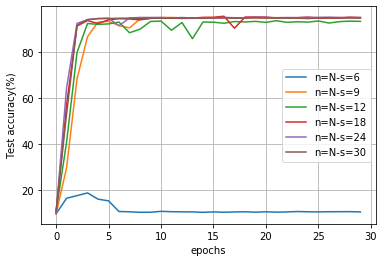

In [272]:
# m_array = np.array([6,9,12,15,18,21,24,27,30])

plot_acc = np.mean(acc_test_arr, axis=1)
print(acc_test_arr.shape)
print(plot_acc.shape)

plt.plot(plot_acc[0,:],label='n=N-s=6')
plt.plot(plot_acc[1,:],label='n=N-s=9')
plt.plot(plot_acc[2,:],label='n=N-s=12')
plt.plot(plot_acc[4,:],label='n=N-s=18')
plt.plot(plot_acc[6,:],label='n=N-s=24')
plt.plot(plot_acc[8,:],label='n=N-s=30')
plt.legend()
plt.grid()
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

import pickle

filehandler = open("./plot/MNIST_LeNet_N31_K12_test_acc","wb")
pickle.dump(acc_test_arr,filehandler)